In [1]:
import os
import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    patch_size = 4  # 2x2, for the Transformer blocks.
    image_size = 256
    expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
    batch_size = 64
    auto = tf.data.AUTOTUNE
    resize_bigger = 280
    num_classes = 5
    learning_rate = 0.002
    label_smoothing_factor = 0.1
    epochs = 300
    early_stopping_patience=20
        

2023-06-25 16:01:53.018567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 16:01:53.043248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 16:01:53.426151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)

2023-06-25 16:01:54.131903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.148560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.148655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf


seeding done!!!


2023-06-25 16:01:54.629393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.629496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.629566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

/home/ml/anaconda3/envs/ml_tf_torch/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# MobileViT utilities

In [5]:
from keras.applications import imagenet_utils

In [6]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = tf.keras.layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = tf.keras.layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = tf.keras.layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = tf.keras.layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = tf.keras.layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = tf.keras.layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = tf.keras.layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = tf.keras.layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return tf.keras.layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = tf.keras.layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / CFG.patch_size)
    non_overlapping_patches = tf.keras.layers.Reshape((CFG.patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = tf.keras.layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = tf.keras.layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

# More on the MobileViT block:

In [7]:
def create_mobilevit(num_classes=5):
    inputs = tf.keras.Input((CFG.image_size, CFG.image_size, 3))
    x = tf.keras.layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * CFG.expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * CFG.expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * CFG.expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * CFG.expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * CFG.expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * CFG.expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * CFG.expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

2023-06-25 16:01:54.998013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.998164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:01:54.998211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 add_1 (Add)                    (None, 64, 64, 24)   0           ['batch_normalization_8[0][0]',  
                                                                  'batch_normalization_5[0][0]']  
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 48)   1152        ['add_1[0][0]']                  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 64, 64, 48)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.nn.silu_6 (TFOpLambda)      (None, 64, 64, 48)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 depthwise

                                                                                                  
 add_5 (Add)                    (None, 4, 256, 64)   0           ['multi_head_attention_1[0][0]', 
                                                                  'add_4[0][0]']                  
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 4, 256, 64)  128         ['add_5[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_2 (Dense)                (None, 4, 256, 128)  8320        ['layer_normalization_3[0][0]']  
                                                                                                  
 dropout_2 (Dropout)            (None, 4, 256, 128)  0           ['dense_2[0][0]']                
          

 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_9 (Add)                    (None, 4, 64, 80)    0           ['multi_head_attention_3[0][0]', 
                                                                  'add_8[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 4, 64, 80)   160         ['add_9[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_6 (Dense)                (None, 4, 64, 160)   12960       ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6

                                                                                                  
 depthwise_conv2d_6 (DepthwiseC  (None, 8, 8, 160)   1440        ['zero_padding2d_3[0][0]']       
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_19 (BatchN  (None, 8, 8, 160)   640         ['depthwise_conv2d_6[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 tf.nn.silu_13 (TFOpLambda)     (None, 8, 8, 160)    0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 8, 8, 80)     12800       ['tf.nn.silu_13[0][0]']          
          

                                                                                                  
 dropout_17 (Dropout)           (None, 4, 16, 96)    0           ['dense_17[0][0]']               
                                                                                                  
 add_20 (Add)                   (None, 4, 16, 96)    0           ['dropout_17[0][0]',             
                                                                  'add_19[0][0]']                 
                                                                                                  
 reshape_5 (Reshape)            (None, 8, 8, 96)     0           ['add_20[0][0]']                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 8, 8, 80)     7760        ['reshape_5[0][0]']              
                                                                                                  
 concatena

# Dataset preparation

In [8]:



def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (CFG.resize_bigger, CFG.resize_bigger))
            image = tf.image.random_crop(image, (CFG.image_size, CFG.image_size, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (CFG.image_size, CFG.image_size))
        label = tf.one_hot(label, depth=CFG.num_classes)
        return image, label

    return _pp


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(CFG.batch_size * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=CFG.auto)
    return dataset.batch(CFG.batch_size).prefetch(CFG.auto)

# Load and prepare the dataset

In [9]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

Number of training examples: 3303
Number of validation examples: 367


# Train a MobileViT (XXS) model

In [10]:

optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing_factor)
# Create a learning rate scheduler callback.
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                      factor=0.7,
                                                      min_delta=0.001,
                                                      patience=3,
                                                      mode="auto")

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=CFG.early_stopping_patience,
    restore_best_weights=True,
    min_delta=0.001,
)

def run_experiment(epochs=CFG.epochs):
    mobilevit_xxs = create_mobilevit(num_classes=CFG.num_classes)
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    mobilevit_xxs.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=CFG.epochs,
        callbacks=[reduceLROnPlat, early_stopping],
    )
#     mobilevit_xxs.load_weights(checkpoint_filepath)
    _, accuracy = mobilevit_xxs.evaluate(val_dataset)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    return mobilevit_xxs


mobilevit_xxs = run_experiment()

Epoch 1/300


2023-06-25 16:01:56.887140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-06-25 16:01:56.887358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-06-25 16:02:03.615750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-25 16:02:05.717348: I tensorflow/compiler/xla/

52/52 [==============================] - ETA: 0s - loss: 1.3495 - accuracy: 0.4675

2023-06-25 16:02:24.584112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-06-25 16:02:24.584315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


52/52 [==============================] - 29s 160ms/step - loss: 1.3495 - accuracy: 0.4675 - val_loss: 1.6752 - val_accuracy: 0.2071 - lr: 0.0020
Epoch 2/300
52/52 [==============================] - 7s 143ms/step - loss: 1.1168 - accuracy: 0.6297 - val_loss: 1.8804 - val_accuracy: 0.1907 - lr: 0.0020
Epoch 3/300
52/52 [==============================] - 7s 142ms/step - loss: 1.0377 - accuracy: 0.6727 - val_loss: 1.8250 - val_accuracy: 0.1907 - lr: 0.0020
Epoch 4/300
52/52 [==============================] - 7s 144ms/step - loss: 0.9852 - accuracy: 0.7057 - val_loss: 1.9653 - val_accuracy: 0.1907 - lr: 0.0020
Epoch 5/300
52/52 [==============================] - 7s 143ms/step - loss: 0.9077 - accuracy: 0.7417 - val_loss: 1.7915 - val_accuracy: 0.1907 - lr: 0.0014
Epoch 6/300
52/52 [==============================] - 7s 144ms/step - loss: 0.8843 - accuracy: 0.7614 - val_loss: 2.6933 - val_accuracy: 0.1907 - lr: 0.0014
Epoch 7/300
52/52 [==============================] - 7s 143ms/step - loss: 

52/52 [==============================] - 7s 143ms/step - loss: 0.4474 - accuracy: 0.9782 - val_loss: 0.6527 - val_accuracy: 0.8937 - lr: 5.6495e-05
Epoch 53/300
52/52 [==============================] - 7s 143ms/step - loss: 0.4440 - accuracy: 0.9800 - val_loss: 0.6605 - val_accuracy: 0.8856 - lr: 5.6495e-05
Epoch 54/300
52/52 [==============================] - 7s 143ms/step - loss: 0.4477 - accuracy: 0.9770 - val_loss: 0.6401 - val_accuracy: 0.8965 - lr: 5.6495e-05
Epoch 55/300
52/52 [==============================] - 7s 141ms/step - loss: 0.4411 - accuracy: 0.9797 - val_loss: 0.6530 - val_accuracy: 0.8883 - lr: 3.9547e-05
Epoch 56/300
52/52 [==============================] - 7s 141ms/step - loss: 0.4417 - accuracy: 0.9855 - val_loss: 0.6525 - val_accuracy: 0.8965 - lr: 3.9547e-05
Epoch 57/300
52/52 [==============================] - 7s 143ms/step - loss: 0.4415 - accuracy: 0.9803 - val_loss: 0.6479 - val_accuracy: 0.8910 - lr: 3.9547e-05
Epoch 58/300
52/52 [===========================

In [11]:
y_pred = mobilevit_xxs.predict(val_dataset.take(1))

2023-06-25 16:12:22.150996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-06-25 16:12:22.151441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [1]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 756ms/step


In [12]:
mobilevit_xxs.evaluate(val_dataset)

6/6 [==============================] - 0s 39ms/step - loss: 0.6478 - accuracy: 0.8992


[0.6477789878845215, 0.8991825580596924]

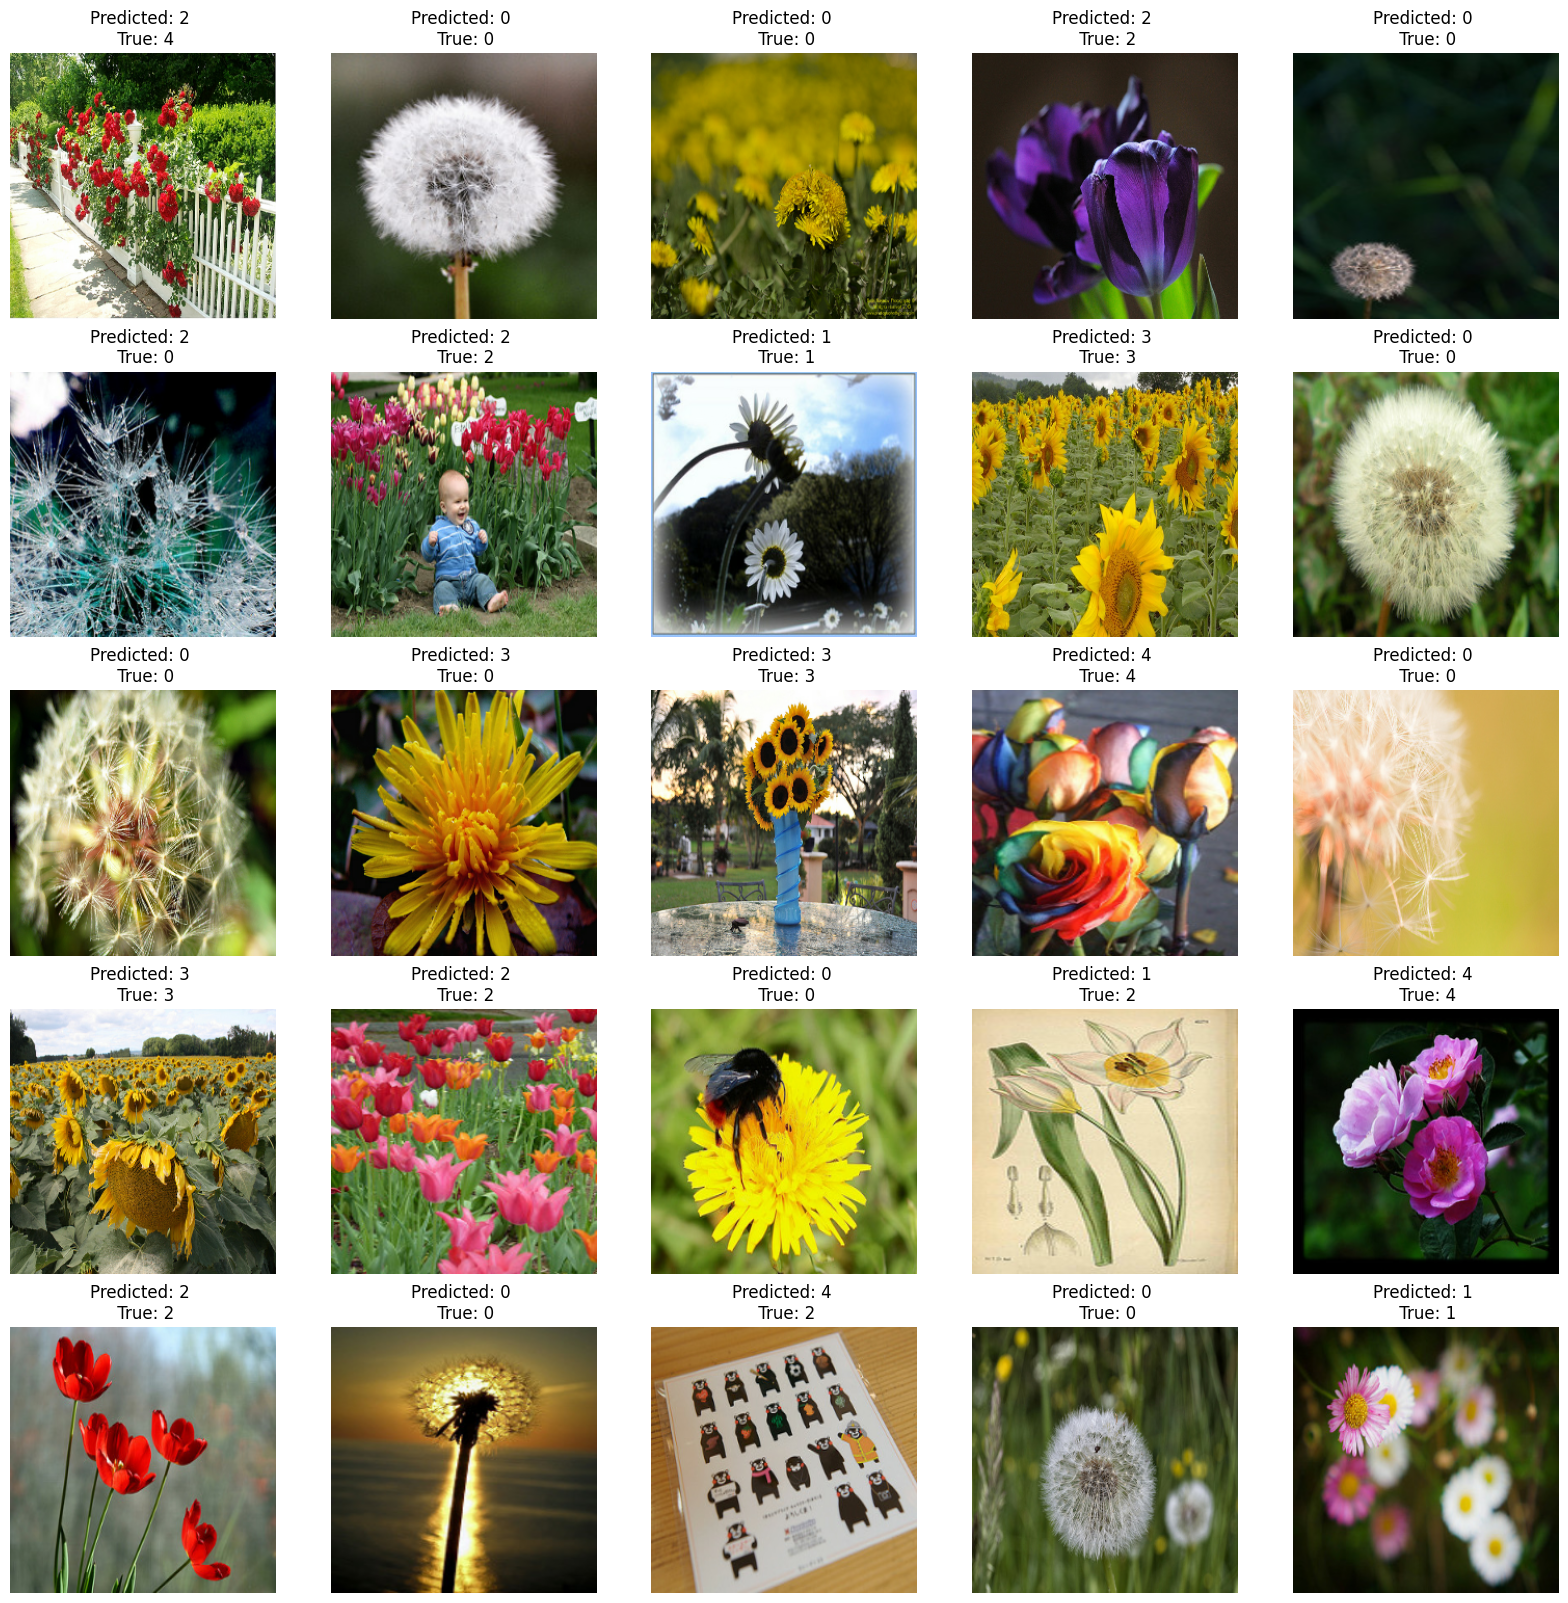

In [13]:
image_batch, label_batch = next(iter(val_dataset))

plt.figure(figsize=(20, 20))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n]/255)
    plt.title(f"Predicted: {np.argmax(y_pred[n])} \n True: {np.argmax(label_batch[n].numpy())}")
    plt.axis("off")